# Zindi Challenge Zindi Admin Notebook



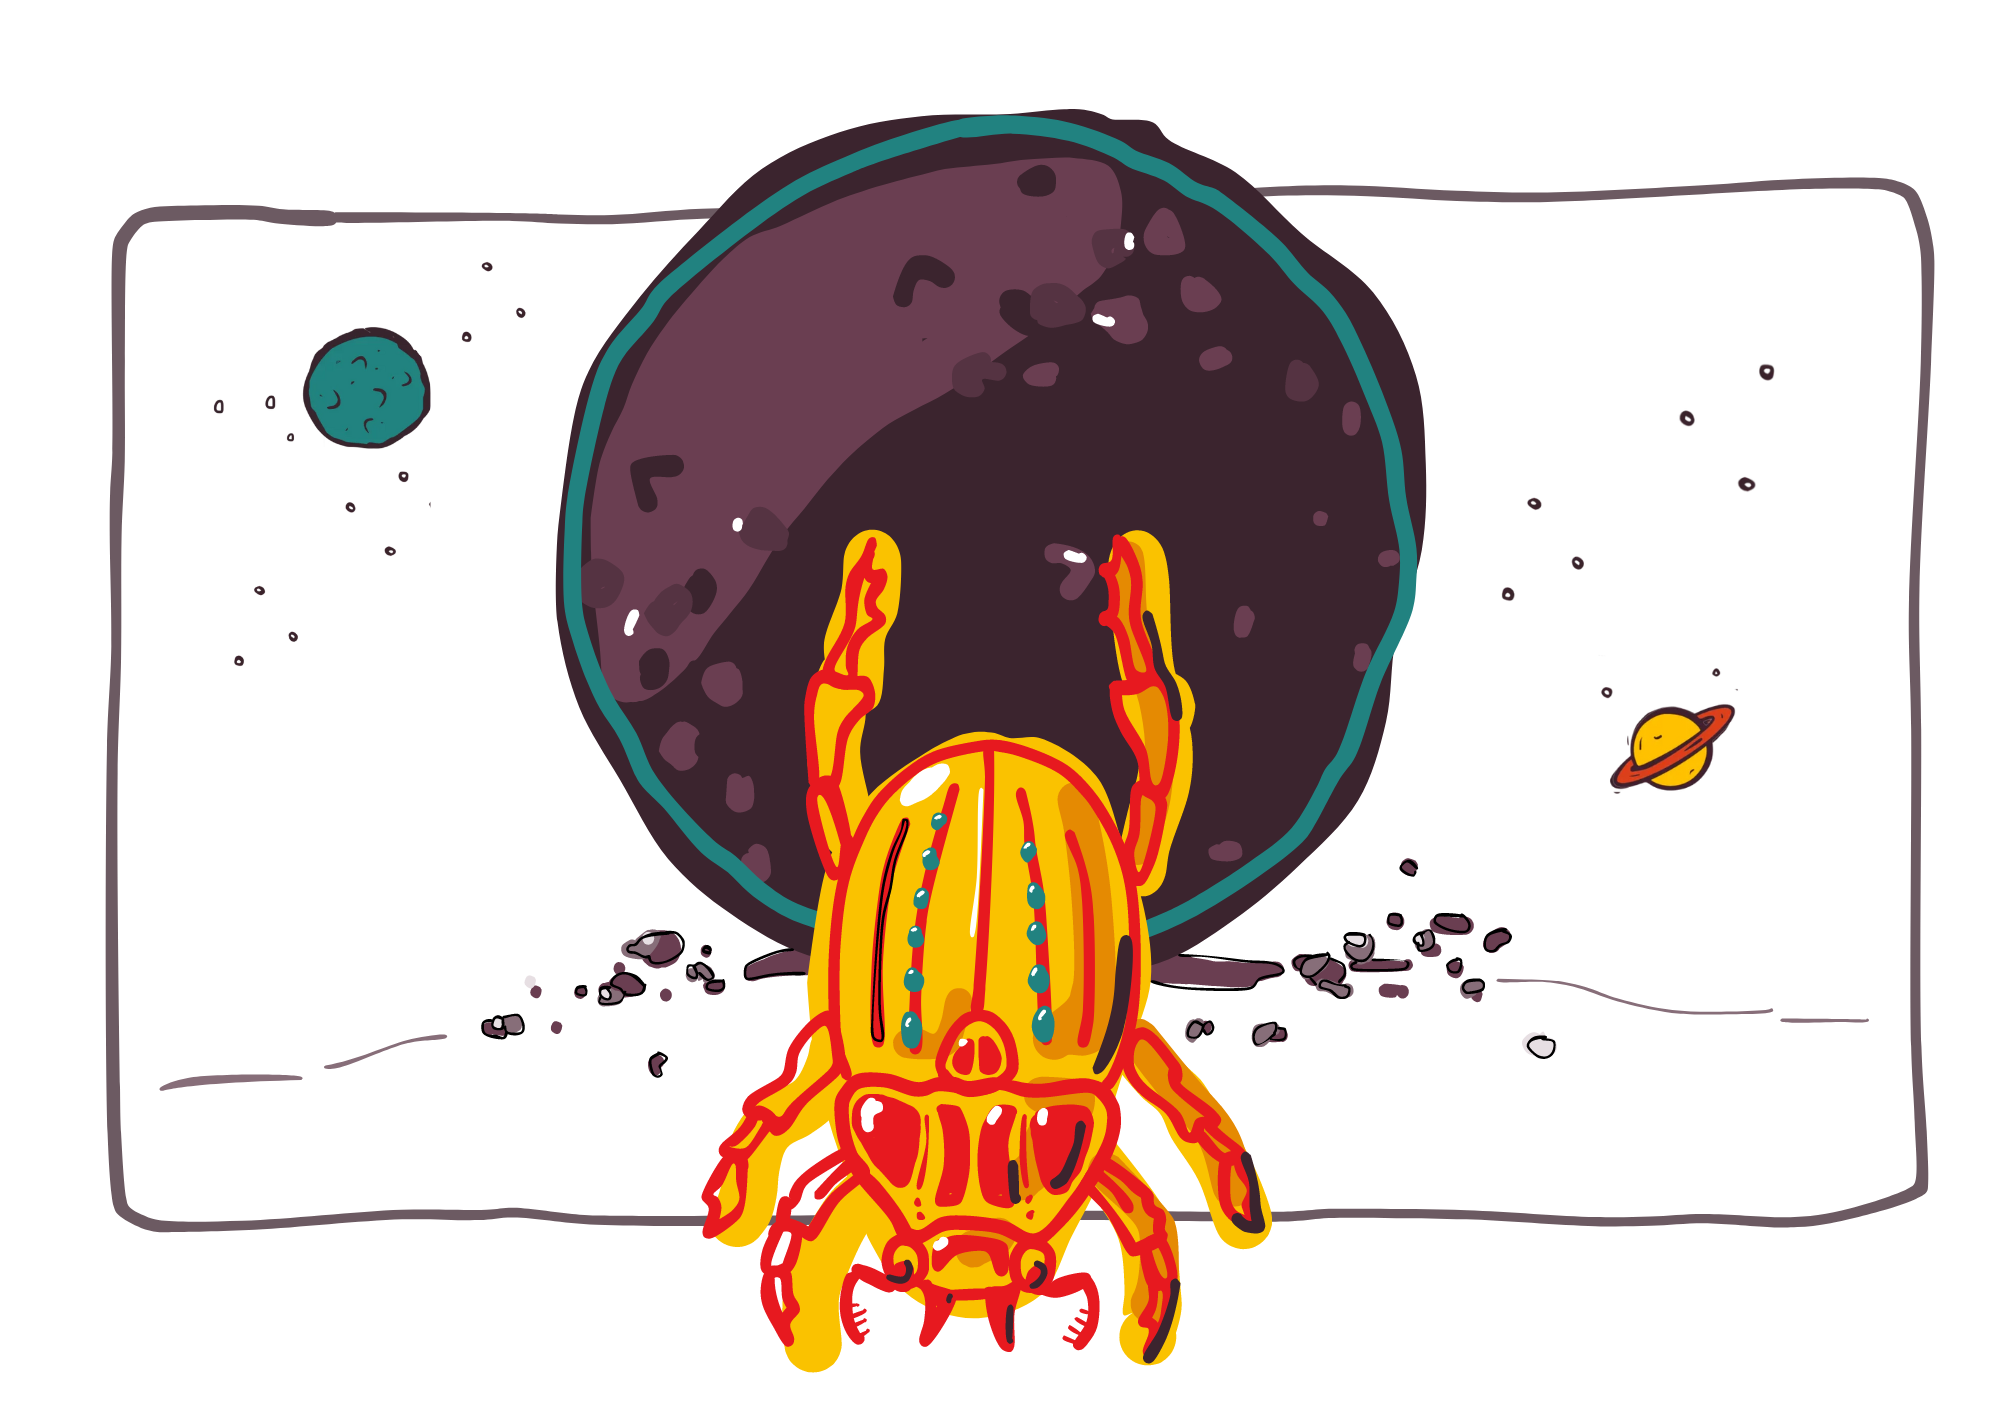

This Notebook and its associated files `model_function.py` and `eval.py` together act to assist participants in:

*   Step 1: testing performance of models on the desired tasks
*   Step 2: create a dev set submisison file to test performance on the Lelapa AI Zindi score
*   Step 3: finally, create a submission file on the test set to upload to the Zindi platform

### 🪲 The InkubaLM
InkubaLM is a Small Langauge Model with functionality in Kiswahili, Hausa, Yoruba, isiZulu and isiXhosa. For simplicity sake we are only including two of these langauges in this challenge (Kiswahili and Hausa) and although the model is a geneartive base model in this case we are only evaluating three tasks - Sentiment Analysis, Machine Translation and AfriXNLI: The ability to derive whether a statement is True, False or Neither (Note: We only do the eng->x direction for translation because that is typically the direction that has the least performance). By testing on 2 langauges and 3 tasks we are able to get a good sense on the gernalisation capability of the model.

### 🏆 The Lelapa AI Zindi score:
The goal of this challenge is to have a model that is smaller than InkubaLM but performs better than InkubaLM. So, the final score is a combination of how well the model performs as well as the model size.

Options to make the model smaller include:

*   Using a new and improved model architecture
*   Using model size reducing techniques

Options to make the model perfrom better include:

*   Prompt engineering to determine the best prompting of outputs
*   Fine tuning of the Inkuba model
*   Model ensembling methods

But methods are not limited to those listed here. And we are excited to see what everyone will come up with.

### 📄 Datasets
Dev - Contains a target. The dev set consists of 100 exmaples for each taska nd each langauge (600 samples in total), you will be required to split this into your own training and test sets.

Test - Does not contain a target. Only consists of 50 samples per langauge per task (300 samples in total). You will need to use the entire set to create you submission file

### 💻 Compute
It is possible to run this notebook on CPU it just takes a while. You are able to change your free notebook to use GPU compute for a limited time and that makes the notebook run much faster. You can also run the functions on your local machine accessing your local CPU/GPU. We have made a concerted efffort to ensure that those who do not have access to significant compute can still participate in this challenge.


Open notebook in Colab -> https://colab.research.google.com/drive/1rGSJT1eCL0Yu-H8fCwen7GKpaD4V6hJD?usp=sharing

## Load Useful functions

We have added some code that allows you to run on GPU if available. You can select:
Runtime -> Change runtime type -> T4 if you are on a colab notebook in order to enable GPU



In [ ]:
#install necessary packeges
!pip install objsize
!pip install sacrebleu
!pip install --upgrade transformers accelerate sentencepiece datasets evaluate -q

**You will need a Huggingface account to be able to access the datasets and the models**

Make sure you have generated an HF_TOKEN and added it to your notebook. You can find instruction son how to do this here https://github.com/google-gemini/gemma-cookbook/blob/main/Gemma/Gemma_Basics_with_HF.ipynb

🚨 NB: In order to access the Inkuba model, make sure you have requested and granted access to the Gated InkubaLM model on huggingface.

In [ ]:
import os
from google.colab import userdata
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
# userdata.get("HF_TOKEN") indicates that the name of the token in the Colab env is HF_TOKEN
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

In [ ]:
# DO NOT EDIT
# create submission file
import pandas as pd
import objsize

def create_submission(model, test_flag):
    """
    This function creates two kinds of submission files. It creates a dev submission
    file for participants to test their score on the dev set before file submission
    as well as the final submission file to be submitted to Zindi

    Inputs
    model: The model in question
    test_flag: TRUE = dummby submission for testig, FALSE = genuine submission file creation
    """

    # PARAM_SIZE of inkuba is 421939200.0
    obj_size = sum(p.numel() for p in model.parameters())

    if test_flag == True:
      filename = 'submission_test.csv'
      try:
        df1 = pd.read_csv('hau_sent_prediction_dev.csv')
        df2 = pd.read_csv('swa_sent_prediction_dev.csv')
        df3 = pd.read_csv('hau_mt_prediction_dev.csv')
        df4 = pd.read_csv('swa_mt_prediction_dev.csv')
        df5 = pd.read_csv('hau_xnli_prediction_dev.csv')
        df6 = pd.read_csv('swa_xnli_prediction_dev.csv')
      except FileNotFoundError as e:
          print("Seems you have not completed all the tasks, please complete all the tasks before attempting to create your submission file")
          raise e
    else:
      filename = 'submission.csv'
      try:
        df1 = pd.read_csv('hau_sent_prediction.csv')
        df2 = pd.read_csv('swa_sent_prediction.csv')
        df3 = pd.read_csv('hau_mt_prediction.csv')
        df4 = pd.read_csv('swa_mt_prediction.csv')
        df5 = pd.read_csv('hau_xnli_prediction.csv')
        df6 = pd.read_csv('swa_xnli_prediction.csv')
      except FileNotFoundError as e:
          print("Seems you have not completed all the tasks, please complete all the tasks before attempting to create your submission file")
          raise e

    res = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
    series = [{'Instruction': 'Model size', 'Input Text': obj_size}]
    submission = pd.concat([res, pd.DataFrame(series)], ignore_index=True)
    submission.to_csv(filename, index=False)

# Step 1: Get results for all the tasks and all the languages and save them to separate CSV files

Esentially this part cycles through each of the languages for each of the tasks (Hausa + Swahili - Sentiment, MT and Xnli). This produces 6 files.

Customisation options:

*   `sample_size` change this to determine how many samples to generate results for, useful for testing
*   `custom_instruct` If you want to use an instruction that is different to what is currently available in the dataset
*   `BASE_PROMPT` change this to change the base prompt
*   `max_new_tokens` this is the number of tokens that are generated, for sentiment and XNLI we expect one word answers tso the number of tokens can be smaller, for translation though the default is 100



In [ ]:
%load_ext autoreload
%autoreload 2
import model_function # functions to load model and run inference
import eval
import datasets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load your model

In [ ]:
from transformers import LlamaTokenizer, LlamaForCausalLM, LlamaConfig,AutoModelForCausalLM, AutoConfig, AutoTokenizer
#add you model here (we have added Inkuba as a placeholder)
model_name = "lelapa/InkubaLM-0.4B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = model_function.load_model(model_name)

The BASE_PROMPT can be changed in a prompt engineering exercise to see whether perfromance can be improved through better prompts. Task instructions can also be adjusted to see if they improve results (ensure to change `custom_instruct=True` in order to use custom instruct statements)

In [ ]:
BASE_PROMPT = "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n ### Instruction: {}\n\n ### Response: "

## Run Sentiment inference and create sentiment files

Load dev datasets for the sentiment task for hausa and swahili

In [ ]:
# Load Hugging Face dataset for sentiment tasks
swa_dataset  = datasets.load_dataset("lelapa/Zindi_sentiment_without_test_target", 'swahili')['dev'] # change the name of dataset here for other tasks
hau_dataset  = datasets.load_dataset("lelapa/Zindi_sentiment_without_test_target", 'hausa')['dev'] # change the name of dataset here for other tasks

Generating dev split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

Load the instruction for sentiment

In [ ]:
# don't change this instruction
sent_instruction = "Please identify the sentiment reflected in this text based on the following guidelines: Positive: if a text implies positive sentiment, attitude, and emotional state. Negative: if a text implies negative sentiment or emotion. Neutral: if a text does not imply positive or negative language directly or indirectly. Provide sentiment labels only"

Run model inference and generate inference files for sentiment

🚨 NB: You can change the `sample_size` here for quicker iteartions during development, to get a real sense of perfromance though we recommend ensuring this sample_size is 50

In [ ]:
#for swahili
model_function.main(model, tokenizer, BASE_PROMPT, sample_size = 3, max_new_tokens=15, task_instruction = sent_instruction, dataset = swa_dataset , csv_file_path='swa_sent_prediction_dev.csv', custom_instruct = False)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


In [ ]:
#for hausa
model_function.main(model, tokenizer, BASE_PROMPT, task_instruction= sent_instruction, dataset= hau_dataset , csv_file_path='hau_sent_prediction_dev.csv', max_new_tokens=15, custom_instruct= False)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Run evaluation on dev results for F1 score for swahili and hausa

🚨 NB: These eval functions aim to give you a better understanding of how your model is perfroming on specific langauges and tasks

In [ ]:
eval.main("/content/swa_sent_prediction_dev.csv")
eval.main("/content/hau_sent_prediction_dev.csv")

Accuracy: 0.6666666666666666, F1 Score: 0.5333333333333333
Accuracy: 0.25, F1 Score: 0.1


## Run MT inference and create MT files

Load Dev sets for MT task for Hausa and Swahili

In [ ]:
hau_dataset  = datasets.load_dataset("lelapa/Zindi_eng_african_without_test_target", 'eng-hau')['dev'] # change the name of dataset here for other tasks
swa_dataset = datasets.load_dataset("lelapa/Zindi_eng_african_without_test_target", 'eng-swa')['dev']

Generating dev split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

Load the instruction for MT

In [ ]:
# don't change this instruction
mt_instruction = "Translate the following from {input_lang} into {output_lang}."

Run model inference and generate inference files for machine translation

In [ ]:
#for hausa
hau_mt_instruction = mt_instruction.format(input_lang = "English", output_lang = "Hausa")
model_function.main(model,
                    tokenizer,
                    BASE_PROMPT,
                    task_instruction = hau_mt_instruction,
                    dataset = hau_dataset,
                    csv_file_path='hau_mt_prediction_dev.csv',
                    custom_instruct= False)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


In [ ]:
#for swahili
swa_mt_instruction = mt_instruction.format(input_lang = "English", output_lang = "Swahili")
model_function.main(model, tokenizer, BASE_PROMPT, task_instruction= swa_mt_instruction, dataset= swa_dataset, csv_file_path='swa_mt_prediction_dev.csv', custom_instruct = False, )

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Run evaluation on dev results for CHrf score for swahili and hausa

In [ ]:
df = pd.read_csv('hau_mt_prediction_dev.csv')
eval.calculate_chrf(df)
df = pd.read_csv('swa_mt_prediction_dev.csv')
eval.calculate_chrf(df)

{'score': 9.15654132204941, 'char_order': 6, 'word_order': 0, 'beta': 2}

## Run Xnli inference and generate inference files for Xnli task

Load Dev and Test sets for Xnli task for Hausa and Swahili

In [ ]:
hau_dataset  = datasets.load_dataset("lelapa/Zindi_Afrixnli_without_test_target", "hau")['dev'] # change the name of dataset here for other tasks
swa_dataset = datasets.load_dataset("lelapa/Zindi_Afrixnli_without_test_target", "swa")['dev'] # change the name of dataset here for other tasks

Generating dev split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

Load the instruction for AfriXnli

In [ ]:
# Instruction is derived from the dataset custom_instruct = False
# If you would like to try your own instruction thenedit the text below and edit:
# custom_instruct = True
xnli_instruction = "Is the following question True, False or Neither?"

Run model inference and generate inference files for machine translation

In [ ]:
#for hausa
model_function.main(model,
                    tokenizer,
                    BASE_PROMPT,
                    task_instruction = xnli_instruction,
                    dataset = hau_dataset,
                    csv_file_path='hau_xnli_prediction_dev.csv',
                    max_new_tokens=15,
                    custom_instruct=False)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


In [ ]:
#for swahili
model_function.main(model, tokenizer, BASE_PROMPT, task_instruction = xnli_instruction, dataset = swa_dataset , csv_file_path='swa_xnli_prediction_dev.csv', max_new_tokens=15, custom_instruct = False)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Run evaluation on dev results for F1Score score for swahili and hausa

In [ ]:
eval.main("/content/swa_xnli_prediction_dev.csv")
eval.main("/content/hau_xnli_prediction_dev.csv")

Accuracy: 0.25, F1 Score: 0.1
Accuracy: 0.25, F1 Score: 0.1


# Step 2: Check how well your model is perfroming on the Lelapa AI Zindi Scoreboard with this custom evaluation function

This calculation combines all the important perfromance metrics into one number that appears on the challenge leader board.

Sudo code:

```
if submitted_model_size < Inkubalm_size:
    percent_scale = submitted_model/Inkubalm
    sent_score = get_f1score (senti_data)
    mt_score = get_human_compared_chrf (MT_data, human_avgs)
    nli_score = get_afriNLI (nli_data)
    final_score = avg(sent_score, mt_score, nli_score) + (1-percent_scale)* avg(sent_score, mt_score, nli_score)
```

## Test your dev set perfromance

To get a test Submission file with the dev set and calculate a score, use the submission file test code below to see what your score is

In [ ]:
create_submission(model, test_flag=True)

In [ ]:
import eval
eval.zindi_score('submission_test.csv')

Score for Sentiment Hausa: 0.1
Score for Sentiment Swahili: 0.5333333333333333
Score for AfriXnli Hausa: 0.1
Score for AfriXnli Swahili: 0.1
Score for MMT: {'score': 9.333274677204189, 'char_order': 6, 'word_order': 0, 'beta': 2}
Average performance score accross tasks and langs:  0.18533321602107505


,Input Text
23,0.151904


# Step 3: Use this code to combine all files into a single submission file

In [ ]:
#model = ""

Once you are satisifed with the perfromance on the dev set, create your prediction files from the test set to create your submission. Note, this uses the `test` dataset

In [ ]:
BASE_PROMPT = "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n ### Instruction: {}\n\n ### Response: "

In [ ]:
# DO NOT EDIT
import time
start_time = time.time()
swa_dataset  = datasets.load_dataset("lelapa/Zindi_sentiment_without_test_target", 'swahili')['test'] # change the name of dataset here for other tasks
hau_dataset  = datasets.load_dataset("lelapa/Zindi_sentiment_without_test_target", 'hausa')['test'] # change the name of dataset here for other tasks
#sent_instruction = '' #edit this if you have a custom instruction
model_function.main(model, tokenizer, BASE_PROMPT, sample_size = 50, task_instruction = sent_instruction, dataset = swa_dataset , csv_file_path='swa_sent_prediction.csv', max_new_tokens=15, custom_instruct = False)
model_function.main(model, tokenizer, BASE_PROMPT, sample_size = 50, task_instruction = sent_instruction, dataset = hau_dataset , csv_file_path='hau_sent_prediction.csv', max_new_tokens=15, custom_instruct = False)


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

In [ ]:
hau_dataset  = datasets.load_dataset("lelapa/Zindi_Afrixnli_without_test_target", "hau")['test'] # change the name of dataset here for other tasks
swa_dataset = datasets.load_dataset("lelapa/Zindi_Afrixnli_without_test_target", "swa")['test'] # change the name of dataset here for other tasks
#xnli_instruction = '' #edit this if you have a custom instruction
model_function.main(
    model,
    tokenizer,
    BASE_PROMPT,
    sample_size = 50,
    task_instruction = xnli_instruction,
    dataset = hau_dataset ,
    csv_file_path='hau_xnli_prediction.csv',
    max_new_tokens=15,
    custom_instruct = False)
model_function.main(model, tokenizer, BASE_PROMPT, sample_size = 50, task_instruction = xnli_instruction, dataset = swa_dataset , csv_file_path='swa_xnli_prediction.csv', max_new_tokens=15, custom_instruct = False)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

In [ ]:
hau_dataset = datasets.load_dataset("lelapa/Zindi_eng_african_without_test_target", 'eng-hau')['test'] # change the name of dataset here for other tasks
swa_dataset = datasets.load_dataset("lelapa/Zindi_eng_african_without_test_target", 'eng-swa')['test']
#xnli_instruction = '' #edit this if you have a custom instruction
#xnli_instruction = '' #edit this if you have a custom instruction
model_function.main(model, tokenizer, BASE_PROMPT, sample_size = 50, task_instruction = hau_mt_instruction, dataset = hau_dataset , csv_file_path='hau_mt_prediction.csv', custom_instruct = False)
model_function.main(model, tokenizer, BASE_PROMPT, sample_size = 50, task_instruction = swa_mt_instruction, dataset = swa_dataset , csv_file_path='swa_mt_prediction.csv', custom_instruct = False)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for o

Now create your submission file. Make sure you name the files correctly so that you do not have issues creating the submission file

In [ ]:
end_time = time.time()
print("Time taken: ", end_time - start_time)

Time taken:  535.0117440223694


In [ ]:
create_submission(model, test_flag=False)

# Step 4: For Zindi team

This function pulls the test dataset from the huggingface server, merges the targets back onto the dataset and runs the same evaluation function on a submission file to determine the Zindi score

Download data from huggingface that has the targets for the test set (no-one else will have access to the URL)

In [ ]:
#install necessary packeges
!pip install objsize
!pip install sacrebleu
!pip install --upgrade transformers accelerate sentencepiece datasets evaluate -q

In [ ]:
import pandas as pd
import datasets

In [ ]:
# order is important
hau_sent  = datasets.load_dataset("lelapa/Zindi_sentiment_with_target", 'hausa')['test'].to_pandas()
swa_sent  = datasets.load_dataset("lelapa/Zindi_sentiment_with_target", 'swahili')['test'].to_pandas()
hau_mmt = datasets.load_dataset("lelapa/Zindi_eng_african_with_target", 'eng-hau')['test'].to_pandas()
swa_mmt = datasets.load_dataset("lelapa/Zindi_eng_african_with_target", 'eng-swa')['test'].to_pandas()
hau_xnli  = datasets.load_dataset("lelapa/Zindi_Afrixnli_with_target", "hau")['test'].to_pandas()
swa_xnli = datasets.load_dataset("lelapa/Zindi_Afrixnli_with_target", "swa")['test'].to_pandas()

Generating dev split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
data = pd.read_csv('submission_test.csv')

In [ ]:
# order is important
res = pd.concat([hau_sent, swa_sent, hau_mmt, swa_mmt, hau_xnli, swa_xnli],ignore_index=True)
merged_submission = pd.concat([res, data], axis=1)
merged_submission.to_csv("submission_to_score.csv")

In [ ]:
eval.zindi_score("submission_to_score.csv")

Score for Sentiment Hausa: 0.1
Score for Sentiment Swahili: 0.5333333333333333
Score for AfriXnli Hausa: 0.1
Score for AfriXnli Swahili: 0.1
Score for MMT: {'score': 9.333274677204189, 'char_order': 6, 'word_order': 0, 'beta': 2}
Average performance score accross tasks and langs:  0.18533321602107505


,Input Text
23,0.151904
